In [0]:
import queue
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist

from core import *

In [0]:
CONTEXT_SIZE = 117 + 1
SAMPLE_COUNT = 2
AGENT_MEMORY_LEN = 4096

EDIBLE_REWARD = 5.0
POISONOUS_REWARD = -35.0

In [0]:
mushroom_dataset = pd.read_csv('mushrooms.csv')
train_labels = mushroom_dataset['class']
train_labels = train_labels.replace(['p', 'e'],
                                    [POISONOUS_REWARD, EDIBLE_REWARD])
# the features contain missing values (marked as ?)
# these are treated as a different class atm
train_features = pd.get_dummies(mushroom_dataset.drop(['class'], axis=1))
train_features = torch.tensor(train_features.values, dtype=torch.float)
train_labels = torch.tensor(train_labels.values)
trainset = torch.utils.data.TensorDataset(train_features, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=1)


In [0]:
class Agent(object):
  
  def __init__(self):
    self.value_estimates = BayesianNN(
        CONTEXT_SIZE, [100, 100, 1],
        [ActivationType.RELU, ActivationType.RELU, ActivationType.NONE])
    self.optimizer = optim.Adam(self.value_estimates.parameters(), lr=0.01)
  
    self.past_plays_context = []
    self.past_plays_action = []
    self.past_plays_reward = []
  
  def collected_data_count(self):
    return len(self.past_plays_context)
  
  def select_action(self, context, logs=False):
    self.value_estimates.train()
    max_reward = POISONOUS_REWARD - 1
    argmax_action = -1
    for action in range(2):
      expected_reward = 0
      for i in range(SAMPLE_COUNT):
        context_and_action = torch.cat(
            [context, torch.tensor([action], dtype=torch.float)])
        expected_reward += self.value_estimates(context_and_action)
      expected_reward /= SAMPLE_COUNT
      if logs:
        print('Action {} - predicted reward: {}'.format(
            action, expected_reward))
      if expected_reward > max_reward:
        max_reward = expected_reward
        argmax_action = action
    return argmax_action
  
  def update_memory(self, context, action, reward):
    self.past_plays_context.append(context)
    self.past_plays_action.append(action)
    self.past_plays_reward.append(reward)
    if len(self.past_plays_context) == AGENT_MEMORY_LEN:
      self.past_plays_context = self.past_plays_context[1:]
      self.past_plays_action = self.past_plays_action[1:]
      self.past_plays_reward = self.past_plays_reward[1:]
    
  
  def update_variational_posterior(self, logs=False):
    features = []
    for context, action in zip(iter(self.past_plays_context),
                               iter(self.past_plays_action)):
      features.append(torch.cat(
          [context, torch.tensor([action], dtype=torch.float)]).unsqueeze(0))
    features = torch.cat(features)
    
    rewards = torch.tensor(self.past_plays_reward, dtype=torch.float)
    
    past_plays_set = torch.utils.data.TensorDataset(features, rewards)
    past_plays_loader = torch.utils.data.DataLoader(
        past_plays_set, batch_size=64, shuffle=True, num_workers=1)
    
    avg_loss = 0
    
    for i, data in enumerate(past_plays_loader):
      inputs, labels = data
      # zero the parameter gradients
      self.optimizer.zero_grad()

      # forward + backward + optimize
      loss, _, _ = self.value_estimates.cost_function(
          inputs, labels, num_samples=2, num_batches=len(past_plays_loader))
      loss.backward()
      self.optimizer.step()
     
      avg_loss += loss
      
    avg_loss /= len(past_plays_loader.dataset)
    
    if logs:
      print('{}. Loss: {}'.format(i, avg_loss))
    return avg_loss    
      

In [0]:
class Environment(object):
  
  def __init__(self, agent, dataloader):
    self.agent = agent
    self.dataloader = dataloader
    self.cumulative_regret = 0
  
  def play_round(self, logs=False):
    loss = 0
    context, eat_reward = next(iter(self.dataloader))
    selected_action = agent.select_action(context[0], logs)
    if selected_action == 0: #not eat
      if eat_reward == EDIBLE_REWARD:
        if logs:
          print('Mushroom is edible; agent chose to pass.')
        self.cumulative_regret += abs(EDIBLE_REWARD)
      else:
        if logs:
          print('Mushroom is poisonous; agent chose to pass.')
      reward = 0
    else: #eat
      if eat_reward == POISONOUS_REWARD:
        self.cumulative_regret += abs(POISONOUS_REWARD)
        if logs:
          print('Mushroom is poisonous; agent chose to eat.')
      else:
        if logs:
          print('Mushroom is edible; agent chose to eat.')
      reward = eat_reward
    if logs:
      print('Cumulative regret is {}'.format(self.cumulative_regret))
    agent.update_memory(context[0], selected_action, reward)
    # if agent.collected_data_count() >= AGENT_MEMORY_LEN - 1:
    loss = agent.update_variational_posterior(logs)
    return loss
    

In [0]:
agent = Agent()
env = Environment(agent, trainloader)

99
Action 0 - predicted reward: tensor([-5.7901], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-5.3044], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 960.0
1. Loss: 357481.875


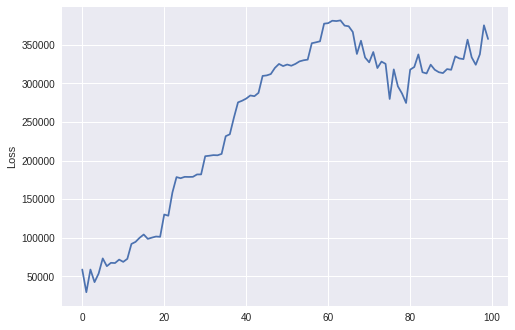

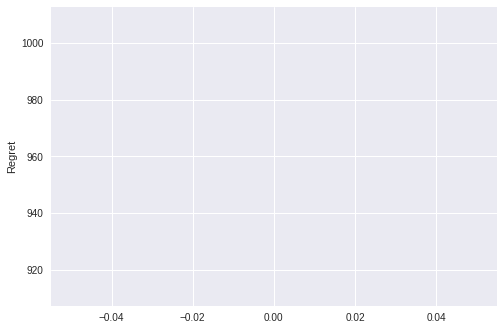

199
Action 0 - predicted reward: tensor([-6.0091], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-5.6692], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 1830.0
3. Loss: 379875.40625


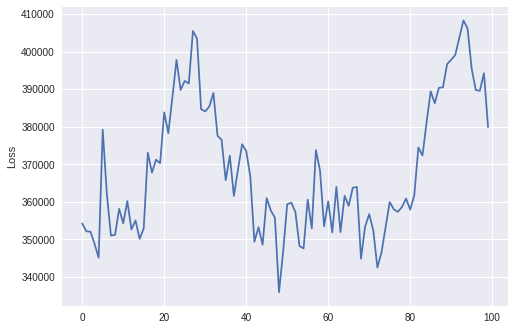

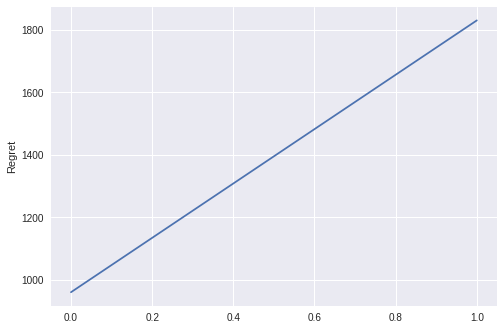

299
Action 0 - predicted reward: tensor([-5.7988], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-5.5863], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 2455.0
4. Loss: 349585.8125


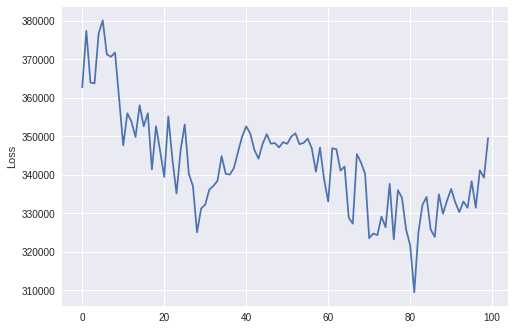

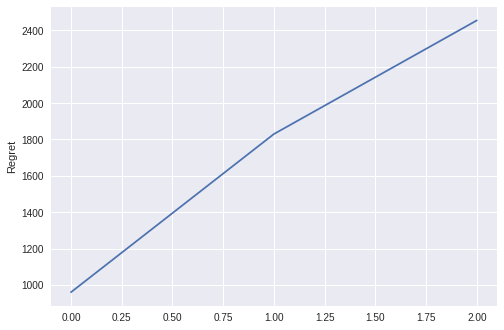

399
Action 0 - predicted reward: tensor([-5.1069], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-5.3346], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 3180.0
6. Loss: 322545.625


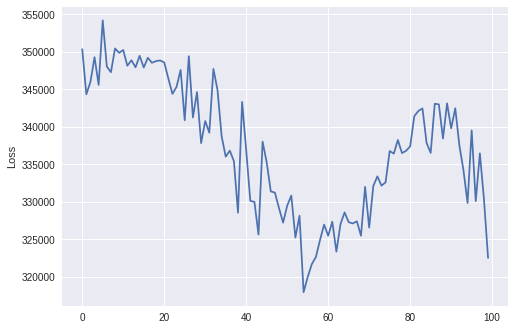

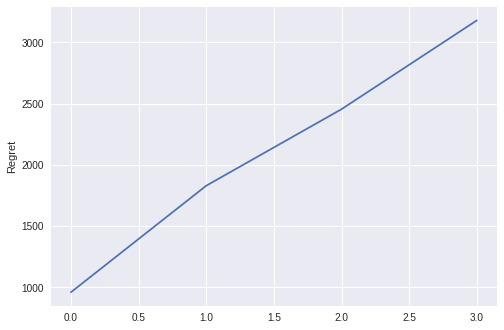

499
Action 0 - predicted reward: tensor([-4.5787], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-4.7085], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 3660.0
7. Loss: 302378.15625


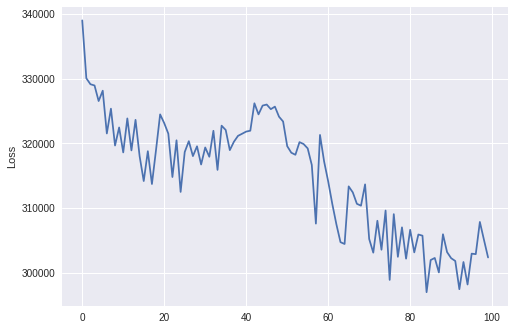

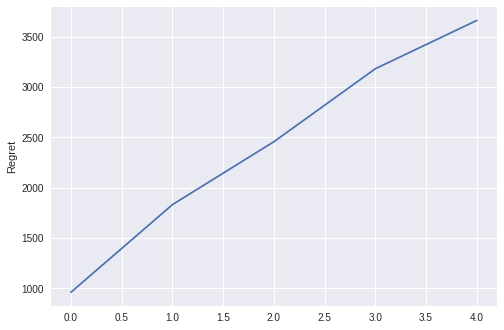

599
Action 0 - predicted reward: tensor([-4.4941], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-4.6838], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 4075.0
9. Loss: 274627.1875


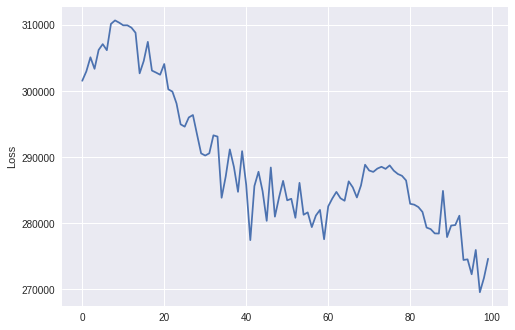

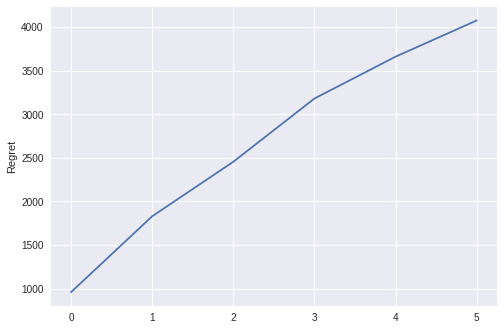

699
Action 0 - predicted reward: tensor([-3.4796], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-3.6465], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 4445.0
10. Loss: 253510.3125


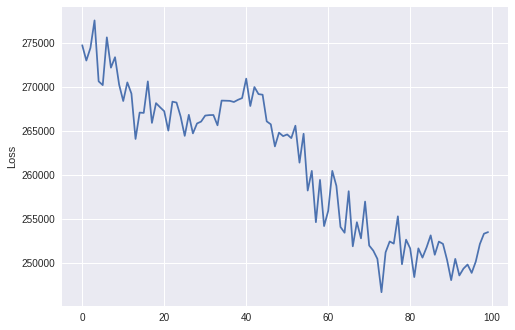

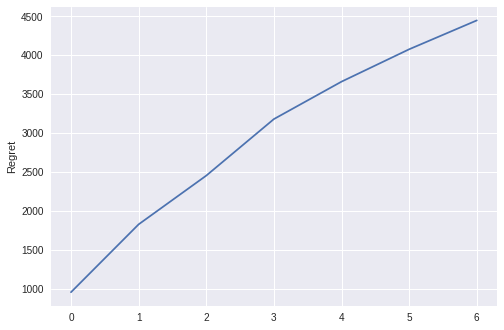

799
Action 0 - predicted reward: tensor([-3.3187], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-3.4087], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 4745.0
12. Loss: 229903.015625


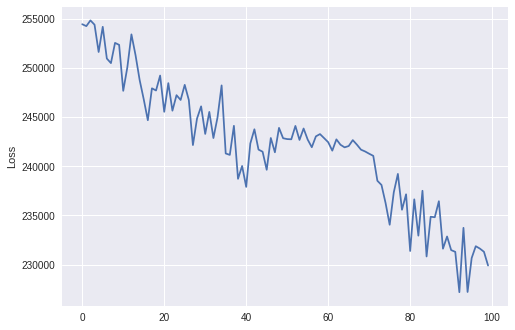

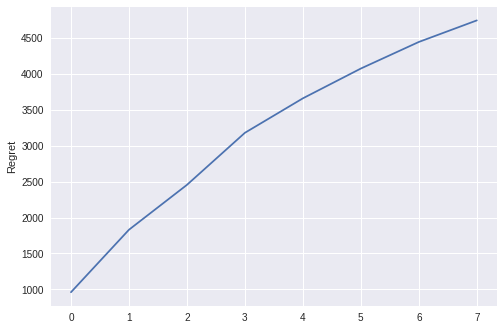

899
Action 0 - predicted reward: tensor([-2.8592], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.9763], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 4890.0
14. Loss: 212027.109375


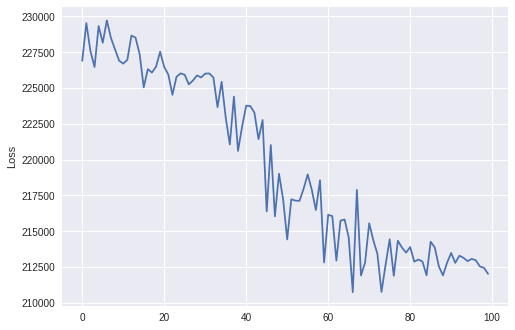

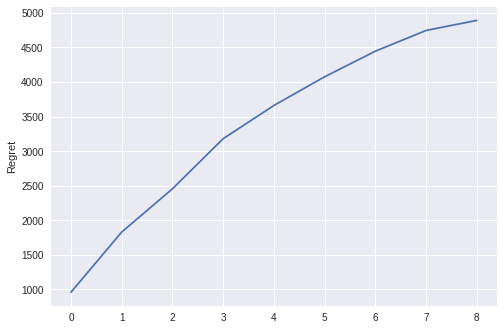

999
Action 0 - predicted reward: tensor([-2.4452], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.4736], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 5000.0
15. Loss: 193831.796875


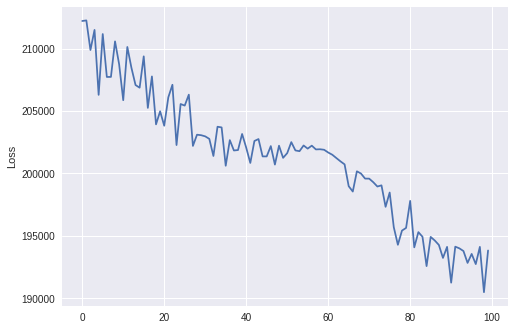

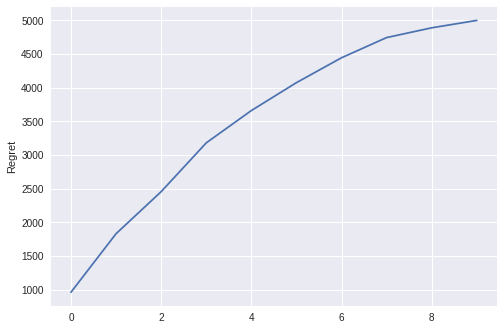

1099
Action 0 - predicted reward: tensor([-2.0589], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.1801], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 5115.0
17. Loss: 176921.796875


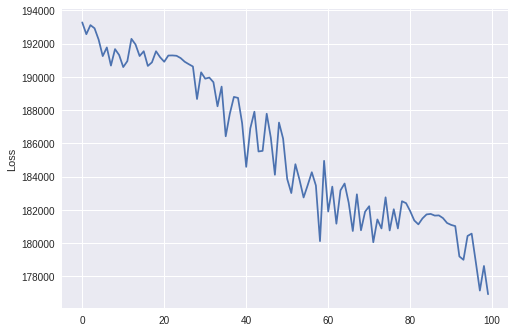

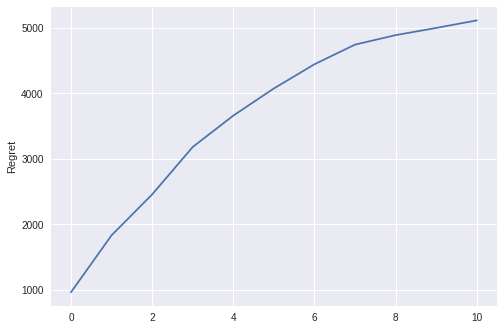

1199
Action 0 - predicted reward: tensor([-1.7640], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.2752], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 5260.0
18. Loss: 166671.984375


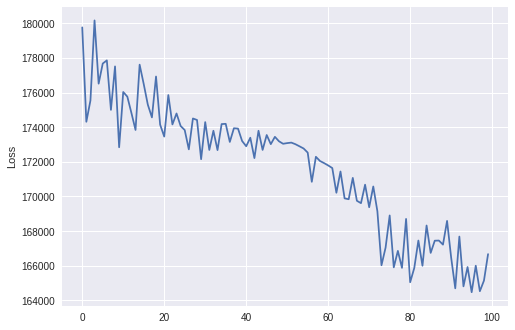

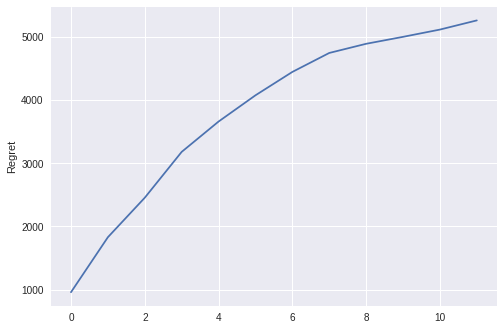

1299
Action 0 - predicted reward: tensor([-1.6368], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-1.6234], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 5430.0
20. Loss: 157521.8125


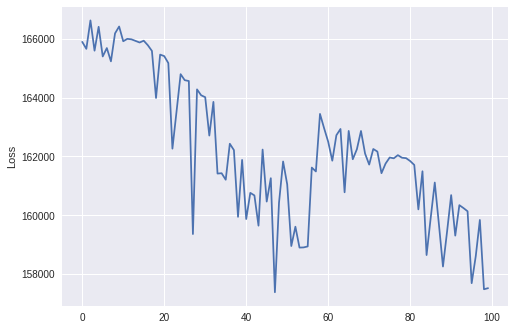

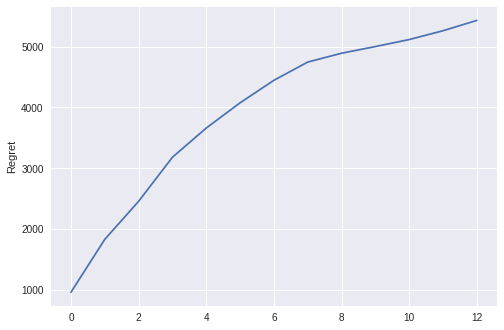

1399
Action 0 - predicted reward: tensor([-1.3854], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.1139], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 5530.0
21. Loss: 149903.59375


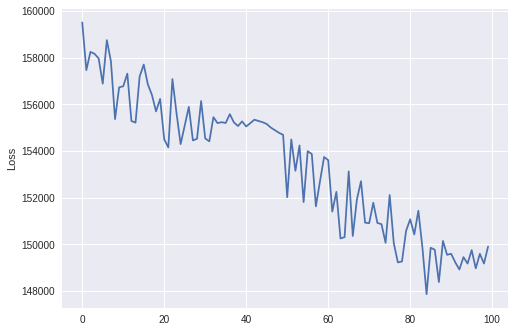

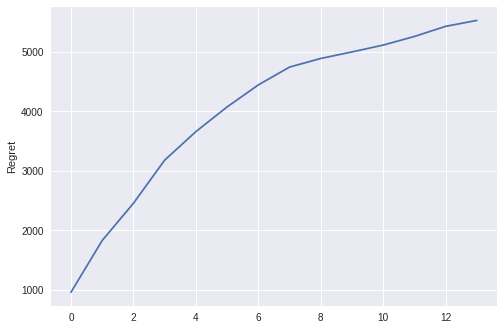

1499
Action 0 - predicted reward: tensor([-1.2762], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-1.2691], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 5730.0
23. Loss: 143281.421875


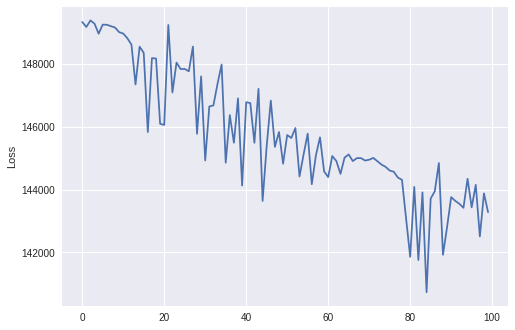

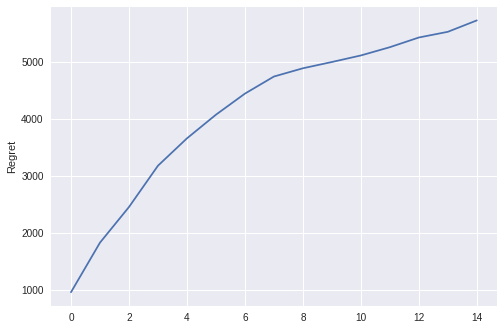

1599
Action 0 - predicted reward: tensor([-1.0440], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-0.6394], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to eat.
Cumulative regret is 5880.0
24. Loss: 137696.21875


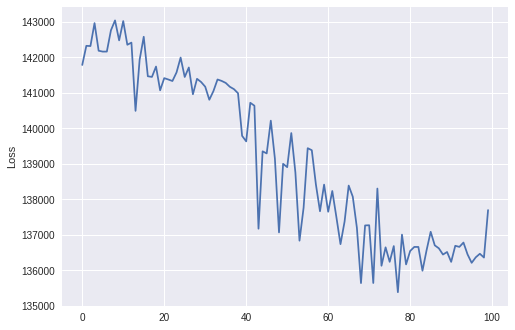

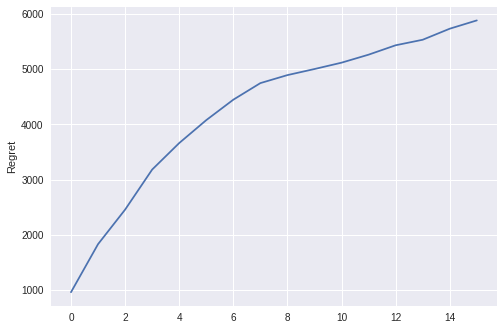

1699
Action 0 - predicted reward: tensor([-1.2288], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-1.2392], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 6385.0
26. Loss: 142834.6875


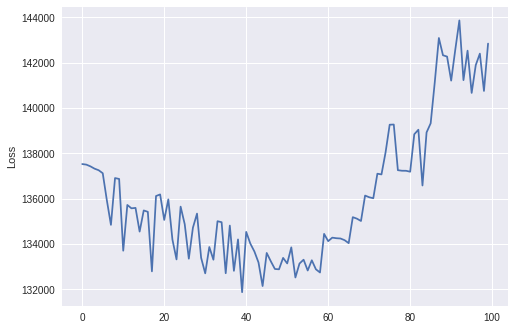

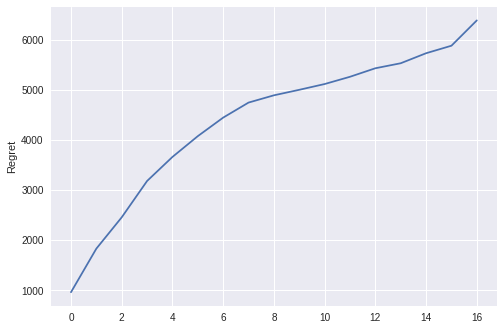

1799
Action 0 - predicted reward: tensor([-1.5022], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-1.4922], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 7330.0
28. Loss: 161964.75


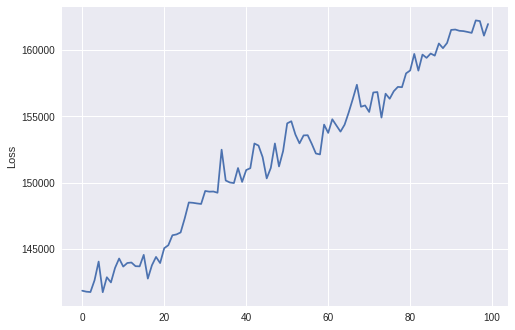

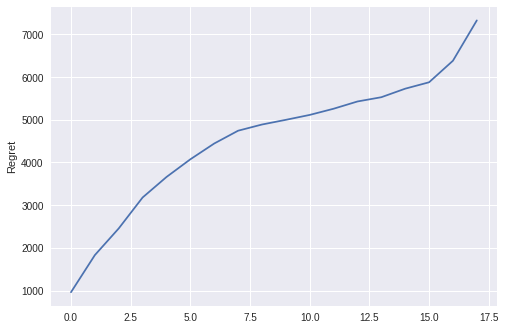

1899
Action 0 - predicted reward: tensor([-1.9007], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-1.8965], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 8415.0
29. Loss: 181020.578125


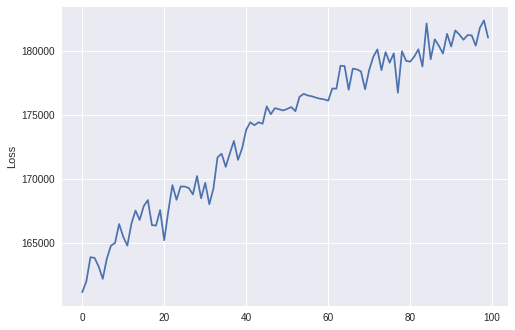

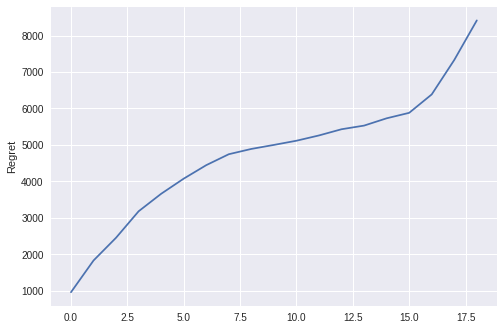

1999
Action 0 - predicted reward: tensor([-2.0435], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.0462], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 9250.0
31. Loss: 193393.578125


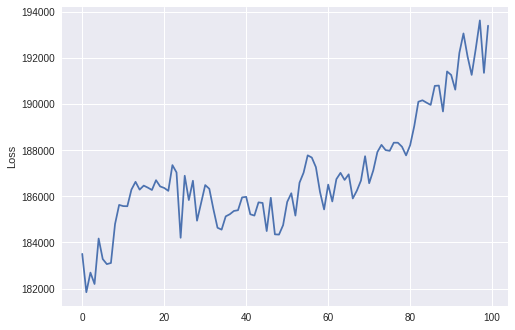

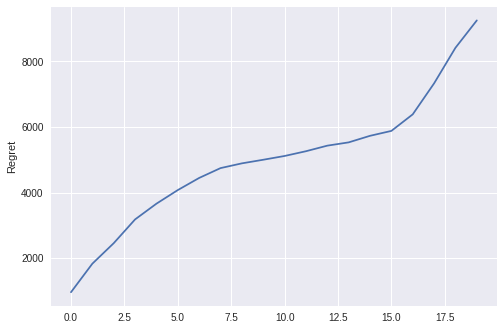

2099
Action 0 - predicted reward: tensor([-2.2724], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.2697], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to eat.
Cumulative regret is 10160.0
32. Loss: 204572.609375


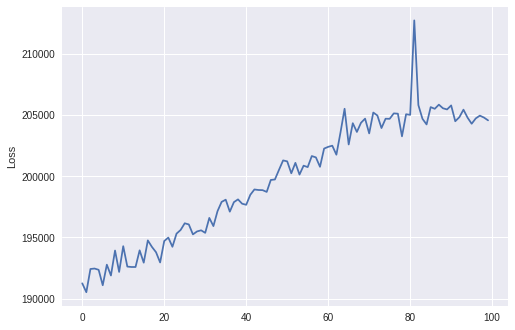

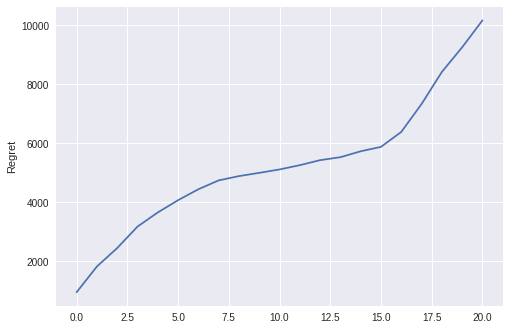

2199
Action 0 - predicted reward: tensor([-2.3948], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.3949], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 10950.0
34. Loss: 213570.1875


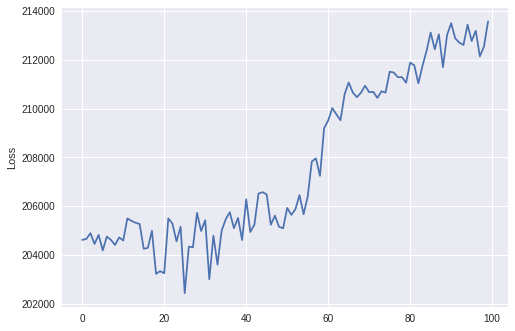

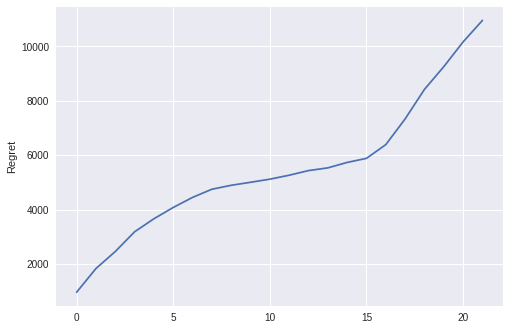

2299
Action 0 - predicted reward: tensor([-2.7163], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.7173], grad_fn=<DivBackward0>)
Mushroom is poisonous; agent chose to pass.
Cumulative regret is 12225.0
35. Loss: 231735.828125


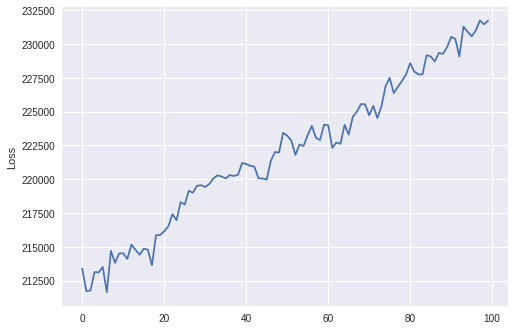

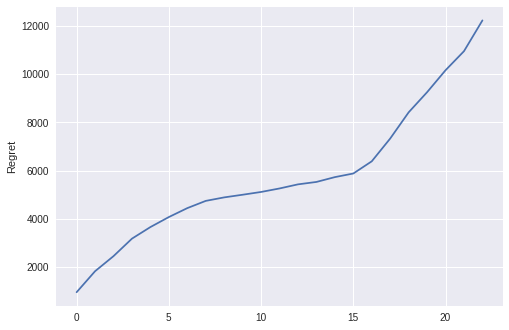

2399
Action 0 - predicted reward: tensor([-2.9643], grad_fn=<DivBackward0>)
Action 1 - predicted reward: tensor([-2.9679], grad_fn=<DivBackward0>)
Mushroom is edible; agent chose to pass.
Cumulative regret is 13360.0
37. Loss: 243403.59375


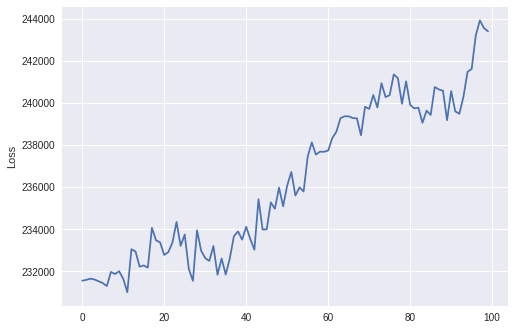

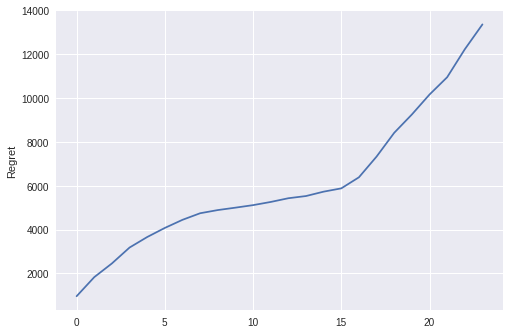

Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(-131.3369, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(-130.6616, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor

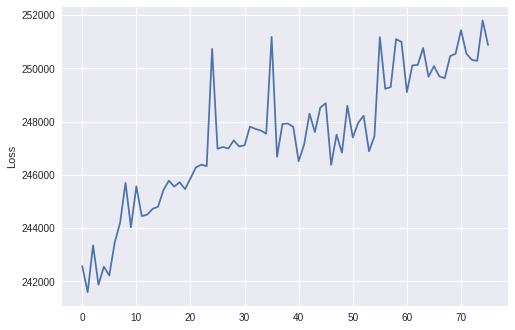

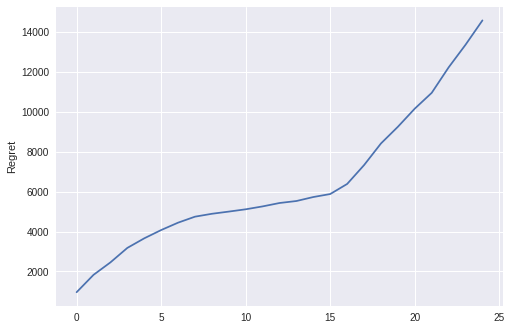

Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Bias log prob: 
tensor(nan, grad_fn=<SumBackward0>)
Weights log prob: 
tensor(nan, grad_f

KeyboardInterrupt: ignored

In [125]:
loss = []
regret = []
for i in range(100000):
  if i == AGENT_MEMORY_LEN:
    print('Started training')
  if (i+1) % 100 == 0:
    print(i)
    loss.append(env.play_round(logs=True))
    regret.append(env.cumulative_regret)
    plt.plot(np.array(loss))
    plt.ylabel('Loss')
    plt.show()
    plt.plot(np.array(regret))
    plt.ylabel('Regret')
    plt.show()
    loss = []
  else:
    loss.append(env.play_round())